                           received_time   altitude          lat          lon  \
1588 2023-07-14 10:52:32.188608670+02:00  11.751824          NaN          NaN   
1589 2023-07-14 10:52:32.281739480+02:00        NaN  460686933.0  112270757.0   
1590 2023-07-14 10:52:35.019687843+02:00  10.769973          NaN          NaN   
1591 2023-07-14 10:52:35.089226787+02:00        NaN  460686033.0  112271637.0   
1592 2023-07-14 10:52:37.858764025+02:00   9.374835          NaN          NaN   

           alt  
1588       NaN  
1589  482238.0  
1590       NaN  
1591  480010.0  
1592       NaN  


/var/folders/4x/r862jfdj31g0f_d96v7w91f80000gp/T/ipykernel_77728/3512858805.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["altitude"][row["closest_idx"]] = row["altitude"]
/var/folders/4x/r862jfdj31g0f_d96v7w91f80000gp/T/ipykernel_77728/3512858805.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["lat"][row["closest_idx"]] = row["lat"]
/var/folders/4x/r862jfdj31g0f_d96v7w91f80000gp/T/ipykernel_77728/3512858805.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

0
                           received_time  packet_text   rssi   altitude  \
11   2023-07-14 10:52:32.270808320+02:00          3.0  -83.0  11.719526   
12   2023-07-14 10:52:32.416785408+02:00          4.0  -86.0  11.667968   
13   2023-07-14 10:52:32.458362368+02:00          2.0  -81.0  11.653283   
14   2023-07-14 10:52:32.559460096+02:00          4.0  -74.0  11.617576   
15   2023-07-14 10:52:32.669641728+02:00          2.0  -77.0  11.578661   
...                                  ...          ...    ...        ...   
2954 2023-07-14 10:59:58.879220736+02:00          3.0  -88.0   2.576210   
2955 2023-07-14 10:59:59.007763456+02:00          2.0  -88.0   2.536744   
2956 2023-07-14 10:59:59.331474944+02:00          4.0  -75.0   2.437357   
2957 2023-07-14 10:59:59.628337664+02:00          2.0  -88.0   2.346214   
2958 2023-07-14 10:59:59.682324736+02:00          5.0 -104.0   2.329639   

            lat        lon            alt       dist  
11    46.068693  11.227076  482238.000000 

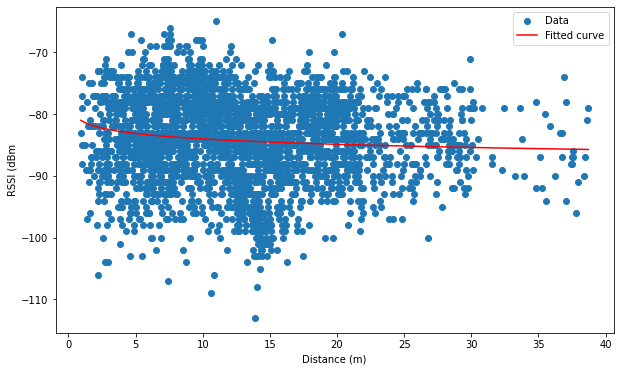

In [9]:
# get gps data and do interpolate

import pandas as pd
import numpy as np

# Select start and end date
start_date = '2023-07-14 10:52:30'
end_date = '2023-07-14 11:00:00'

# Load the CSV data_gps into a data_gpsFrame
data_gps = pd.read_csv('data_0714/pixhawk_gps_1689322326086276514.csv', skipinitialspace=True)

# Convert received_time to datetime format
data_gps['received_time'] = pd.to_datetime(data_gps['received_time'], unit='ns')

# Localize the timestamp to GMT first (assuming the original time is in GMT)
data_gps['received_time'] = data_gps['received_time'].dt.tz_localize('GMT')

# Convert to Rome time
data_gps['received_time'] = data_gps['received_time'].dt.tz_convert('Europe/Rome')

# Filter data based on the date range
mask = (data_gps['received_time'] > start_date) & (data_gps['received_time'] <= end_date)
data_gps = data_gps.loc[mask]

print(data_gps.head())

# Sort the DataFrame by received_time
data_gps = data_gps.sort_values('received_time')

# Replace empty strings with NaN
data_gps.replace('', np.nan, inplace=True)

# Set received_time as the index (required for interpolation)
data_gps.set_index('received_time', inplace=True)

# Interpolate the missing values based on the index (received_time)
data_gps_interpolated = data_gps.astype('float').interpolate(method='time')

# Reset the index
data_gps_interpolated.reset_index(inplace=True)

data_gps_interpolated = data_gps_interpolated.drop(data_gps_interpolated.index[0])

# Divide by a large number to get latitude and longitude values in the correct range
data_gps_interpolated['lat'] = data_gps_interpolated['lat'] / 1e7
data_gps_interpolated['lon'] = data_gps_interpolated['lon'] / 1e7

# Print the resulting DataFrame

data_gps_interpolated
data_gps.reset_index(inplace=True)
# get lora data

import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
data_lora = pd.read_csv('data_0714/lora_module_received_1689321731873899299.csv', skipinitialspace=True)

# Filter the DataFrame
data_lora = data_lora[data_lora['packet_text'].isin(['2', '3', '4', '5'])]

# Convert the received_time to datetime format
data_lora['received_time'] = pd.to_datetime(data_lora['received_time'], unit='ns')

# Localize the timestamp to GMT first (assuming the original time is in GMT)
data_lora['received_time'] = data_lora['received_time'].dt.tz_localize('GMT')

# Convert to Rome time
data_lora['received_time'] = data_lora['received_time'].dt.tz_convert('Europe/Rome')

# Filter data based on the date range
mask = (data_lora['received_time'] > start_date) & (data_lora['received_time'] <= end_date)
data_lora = data_lora.loc[mask]

data_lora
# merge gps and lora data

# Load the dataframes
df1 = data_gps_interpolated

df2 = data_lora
df2["altitude"] = np.nan
df2["lat"] = np.nan
df2["lon"] = np.nan
df2["alt"] = np.nan

# Define a function to find the index of the closest timestamp in df2
def find_closest(row):
    diff = np.abs(df2['received_time'] - row['received_time'])
    idx = diff.idxmin()
    return idx

# Apply the function to each row in df1
df1['closest_idx'] = df1.apply(find_closest, axis=1)

for index, row in df1.iterrows():
    df2["altitude"][row["closest_idx"]] = row["altitude"]
    df2["lat"][row["closest_idx"]] = row["lat"]
    df2["lon"][row["closest_idx"]] = row["lon"]
    df2["alt"][row["closest_idx"]] = row["alt"]

# Set received_time as the index (required for interpolation)
df2.set_index('received_time', inplace=True)

# Interpolate the missing values based on the index (received_time)
df2_interpolated = df2.astype('float').interpolate(method='time')

# Reset the index
df2_interpolated.reset_index(inplace=True)

df2_interpolated = df2_interpolated.drop(df2_interpolated.index[:df2_interpolated.isna().any(axis=1).sum()])

print(df2_interpolated.isna().any(axis=1).sum())

df2_interpolated
# calculate distance and add column

import pandas as pd
import numpy as np
from math import radians, cos, sin, sqrt, atan2
import pyproj
import folium

# Load the dataframes
beacon_locations = pd.read_csv('data_0714/beacon_location_small.csv', skipinitialspace=True)

# Create a map centered around the average latitude and longitude
m = folium.Map(location=[beacon_locations['lat'].mean(), beacon_locations['lon'].mean()], zoom_start=15)

# Add a marker for each beacon
for _, row in beacon_locations.iterrows():
    folium.Marker([row['lat'], row['lon']], popup='Beacon {}'.format(row['beacon_id'])).add_to(m)

# Display the map
m


# Define a function to calculate the distance between two points
def to_cartesian(lat, lon, alt):
    x, y, z = pyproj.Transformer.from_crs(4979, 4978, always_xy=True).transform(lon, lat, alt)
    return x, y, z

def calculate_distance(lat1, lon1, alt1, lat2, lon2, alt2):
    x1, y1, z1 = to_cartesian(lat1, lon1, alt1)
    x2, y2, z2 = to_cartesian(lat2, lon2, alt2)
    distance = sqrt((x1-x2)**2+(y1-y2)**2+(z1-z2)**2)

    return distance

df2_interpolated["dist"] = np.nan

for index, row in df2_interpolated.iterrows():
    beacon_info = beacon_locations.loc[beacon_locations["beacon_id"]==int(row["packet_text"])]
    beacon_locations.loc[beacon_locations["beacon_id"]==4]

    df2_interpolated["dist"][index] = calculate_distance(beacon_info["lat"].values[0], beacon_info["lon"].values[0], 0, row["lat"], row["lon"], row["altitude"])
# Print the resulting dataframe
print(df2_interpolated)
# curve fit with all beacons

import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the function to fit
def func(d, n, C):
    return -10 * n * np.log10(d) + C

# Fit the function to the data
popt, pcov = curve_fit(func, df2_interpolated['dist'], df2_interpolated['rssi'])

# Print the optimal parameters
print('n =', popt[0])
print('C =', popt[1])

# Plot the data and the fitted curve
plt.figure(figsize=(10, 6))
plt.scatter(df2_interpolated['dist'], df2_interpolated['rssi'], label='Data')
distances = np.linspace(df2_interpolated['dist'].min(), df2_interpolated['dist'].max(), 1000)
plt.plot(distances, func(distances, *popt), 'r', label='Fitted curve')
plt.xlabel('Distance (m)')
plt.ylabel('RSSI (dBm')
plt.legend()
plt.show()



In [10]:
df2_interpolated["packet_text"] = df2_interpolated["packet_text"].astype(int) -2
df2_interpolated

,received_time,packet_text,rssi,altitude,lat,lon,alt,dist
11,2023-07-14 10:52:32.270808320+02:00,1,-83.0,11.719526,46.068693,11.227076,482238.000000,36.721748
12,2023-07-14 10:52:32.416785408+02:00,2,-86.0,11.667968,46.068689,11.227080,482120.022716,37.540851
13,2023-07-14 10:52:32.458362368+02:00,0,-81.0,11.653283,46.068687,11.227082,482086.420615,24.868581
14,2023-07-14 10:52:32.559460096+02:00,2,-74.0,11.617576,46.068684,11.227085,482004.714400,36.935785
15,2023-07-14 10:52:32.669641728+02:00,0,-77.0,11.578661,46.068680,11.227088,481915.666661,24.090113
...,...,...,...,...,...,...,...,...
2954,2023-07-14 10:59:58.879220736+02:00,1,-88.0,2.576210,46.068569,11.227259,475159.604251,16.008114
2955,2023-07-14 10:59:59.007763456+02:00,0,-88.0,2.536744,46.068567,11.227261,475097.245216,5.704437
2956,2023-07-14 10:59:59.331474944+02:00,2,-75.0,2.437357,46.068564,11.227267,474940.205316,16.025870
2957,2023-07-14 10:59:59.628337664+02:00,0,-88.0,2.346214,46.068561,11.227272,474796.190372,5.177734


In [11]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pyproj
from pykalman import KalmanFilter
from tqdm import tqdm

###
# Select different time spans
# start_date = '2023-07-14 10:23:30+02:00'
# end_date = '2023-07-14 10:26:00+02:00'
# start_date = '2023-07-14 10:39:30+02:00'
# end_date = '2023-07-14 10:42:30+02:00'
# start_date = '2023-07-14 10:30:00+02:00'
# end_date = '2023-07-14 10:33:00+02:00'
start_date = '2023-07-14 10:52:30+02:00'
end_date = '2023-07-14 10:55:30+02:00'

start_date_datetime = pd.to_datetime(start_date)
end_date_datetime = pd.to_datetime(end_date)

# Filter data based on the date range
mask = (df2_interpolated['received_time'] > start_date) & (df2_interpolated['received_time'] <= end_date)
df2_interpolated = df2_interpolated.loc[mask]
d_list = []
###

sample_time = 10
update_time = 1

results_3d = []
results_2d = []

estimated_locations_cartesian = []
estimated_locations_cartesian_after_kalman = []
estimated_locations_before_kalman = []
estimation_std = []
estimated_locations = []
answer_locations = []

first_estimation = True

def to_gps_2d(x, y, zone, hemisphere):
    # define the coordinate systems
    transformer = pyproj.Transformer.from_crs(f"epsg:326{zone if hemisphere == 'north' else zone + 100}", "epsg:4326")
    
    lat, lon = transformer.transform(x, y)
    return [lat, lon]

# Convert GPS coordinates to Cartesian coordinates
def to_cartesian(lat, lon, alt):
    x, y, z = pyproj.Transformer.from_crs(4979, 4978, always_xy=True).transform(lon, lat, alt)
    return x, y, z

# # Convert GPS coordinates to Cartesian coordinates
def to_cartesian_2d(lat, lon):
    # Calculate UTM zone from longitude
    zone = int((lon + 180) / 6) + 1
    # Determine if the point is in the Northern or Southern hemisphere
    hemisphere = 'north' if lat >= 0 else 'south'

    # define the coordinate systems
    transformer = pyproj.Transformer.from_crs("epsg:4326", f"epsg:326{zone if lat >= 0 else zone + 100}")

    x, y = transformer.transform(lat, lon)
    return x, y

# Convert Cartesian coordinates to GPS coordinates
def to_gps(x, y, z):
    lon, lat, alt = pyproj.Transformer.from_crs(4978,4979, always_xy=True).transform(x, y, z)
    return lat, lon, alt

# Calculate the distance between the receiver and each source
def distance(xyz_receiver, xyz_source):
    return np.linalg.norm(xyz_source - xyz_receiver)

delta = 10  # Huber parameter, can be tuned

def huber_loss(errors):
    return np.where(np.abs(errors) < delta, 0.5 * errors**2, delta * (np.abs(errors) - 0.5 * delta))

def error(xyz_receiver, xyz_sources, d):
    distances = np.linalg.norm(xyz_sources - xyz_receiver, axis=1)
    errors = distances - d
    large_errors = np.abs(errors) >= delta
    errors_array.append(np.sqrt(errors**2))
    return np.sum(huber_loss(errors))

# Constraint function to ensure the estimated location has the same altitude as the wanted location
def altitude_constraint(xyz_receiver_estimated, altitude):
    lat, lon, alt = to_gps(*xyz_receiver_estimated)
    x, y, z = to_cartesian(lat, lon, altitude)
    return xyz_receiver_estimated[2] - z

# Define a function to convert radians to degrees
def degrees(rad):
    return rad * 180 / np.pi

def kalman(measurements):
    # Let's say we have some 3D measurements
    # measurements = np.array([[1, 2, 3], [1.1, 1.9, 3.1], [0.9, 2.1, 2.9], ...]) # fill this with your data

    n_timesteps, n_dim = measurements.shape
    n_state = 2 * n_dim

    # We will assume the initial position is the first measurement, and initial velocity is 0
    initial_state_mean = np.zeros(n_state)
    initial_state_mean[:n_dim] = measurements[0]

    # Initial estimation error covariance
    initial_state_covariance = np.eye(n_state)

    # Time step
    dt = 1  # assuming the measurements are 0.1 second apart

    # Transition matrix
    transition_matrix = np.eye(n_state)
    transition_matrix[:n_dim, n_dim:] = dt * np.eye(n_dim)

    # Transition covariance
    transition_covariance = np.eye(n_state)
    transition_covariance[n_dim:, n_dim:] *= 0.01  # assume we're more certain about the velocity than the position

    # Observation matrix
    observation_matrix = np.zeros((n_dim, n_state))
    observation_matrix[:, :n_dim] = np.eye(n_dim)

    # Observation covariance
    observation_covariance = np.eye(n_dim) * 10

    # Now we can initialize the Kalman Filter
    kf = KalmanFilter(
        initial_state_mean=initial_state_mean,
        initial_state_covariance=initial_state_covariance,
        transition_matrices=transition_matrix,
        transition_covariance=transition_covariance,
        observation_matrices=observation_matrix,
        observation_covariance=observation_covariance,
    )

    # We can use the filter method to apply the Kalman Filter to the measurements
    state_means, state_covariances = kf.filter(measurements)

    # Extract estimated positions and velocities
    positions_estimated = state_means[:, :n_dim]
    velocities_estimated = state_means[:, n_dim:]

    # Extract position and velocity uncertainties
    position_uncertainties = state_covariances[:, :n_dim, :n_dim]
    velocity_uncertainties = state_covariances[:, n_dim:, n_dim:]

    # Extract position and velocity standard deviations
    position_std = np.sqrt(np.diagonal(position_uncertainties, axis1=1, axis2=2))
    velocity_std = np.sqrt(np.diagonal(velocity_uncertainties, axis1=1, axis2=2))

    return positions_estimated, position_std

for i in tqdm(range(int((end_date_datetime-start_date_datetime)/pd.Timedelta(seconds=update_time)))):
    ###
    sample_rssi = df2_interpolated.loc[(df2_interpolated['received_time'] >= (start_date_datetime + pd.Timedelta(seconds=update_time*i)).strftime('%Y-%m-%d %H:%M:%S')) & (df2_interpolated['received_time'] <= (start_date_datetime + pd.Timedelta(seconds=update_time*i+sample_time)).strftime('%Y-%m-%d %H:%M:%S'))]
    average_rssi = sample_rssi.groupby('packet_text')['rssi'].mean()
    average_distance = average_rssi.apply(lambda x: 10**((-83.88973503142876 - x) / (10 * 0.008201367056655195)))
    d = average_distance.tolist()
    d_list.append(d)
    ###

    node_numbers = list(map(int, average_distance.index)) 
    ###
# 2,46.068583,11.227323
# 3,46.068436,11.227332
# 4,46.068450,11.227389
# 5,46.068568,11.227252
    source_locations = [(46.068583,11.227323, 0), (46.068436,11.227332, 0), (46.068450,11.227389, 0), (46.068568,11.227252, 0)]
    ###
    source_locations = [source_locations[i] for i in node_numbers]

    ###
    answer_location = [sample_rssi.tail(1)["lat"].values[0], sample_rssi.tail(1)["lon"].values[0], sample_rssi.tail(1)["altitude"].values[0]]
    ###

    errors_array = []

    # Starting GPS coordinates of the receiver (can be anywhere)
    receiver_location = (*source_locations[d.index(min(d))][:2],100)

    # Convert the GPS coordinates of the sources and the receiver to Cartesian coordinates
    xyz_sources = np.array([to_cartesian(*source_location) for source_location in source_locations])
    xyz_receiver = np.array(to_cartesian(*receiver_location))

    # Perform multilateration to estimate the location of the receiver
    
    # result = minimize(error, xyz_receiver, args=(xyz_sources, d))
    altitude = answer_location[2]
    result = minimize(error, xyz_receiver, args=(xyz_sources, d), constraints=[{'type': 'eq', 'fun': altitude_constraint, 'args': (altitude,)}])
    xyz_receiver_estimated = result.x

    # Store raw results in cartesian coords
    estimated_locations_cartesian.append(xyz_receiver_estimated)
    estimated_locations_before_kalman.append(to_gps(*xyz_receiver_estimated))

    # if first_estimation:
    #     first_estimation = False
    #     estimation_std.append(0)
    # else:
    #     # Apply kalman filter
    #     kalman_position, kalman_std = kalman(np.array(estimated_locations_cartesian))
    #     xyz_receiver_estimated = kalman_position[-1]
    #     estimation_std.append(kalman_std[-1])

    # Convert the estimated Cartesian coordinates of the receiver back to GPS coordinates
    estimated_locations_cartesian_after_kalman.append(xyz_receiver_estimated)
    receiver_location_estimated = to_gps(*xyz_receiver_estimated)


    results_3d.append(np.linalg.norm(to_cartesian(*answer_location)-xyz_receiver_estimated))
    results_2d.append(np.linalg.norm(np.array(to_cartesian_2d(*answer_location[:2])) - np.array(to_cartesian_2d(*receiver_location_estimated[:2]))))
    estimated_locations.append([i*update_time+sample_time,receiver_location_estimated])
    answer_locations.append(answer_location)

 46%|████▌     | 83/180 [12:32<20:19, 12.57s/it]/var/folders/4x/r862jfdj31g0f_d96v7w91f80000gp/T/ipykernel_77728/3036371551.py:87: RuntimeWarning: overflow encountered in square
  errors_array.append(np.sqrt(errors**2))
/var/folders/4x/r862jfdj31g0f_d96v7w91f80000gp/T/ipykernel_77728/3036371551.py:81: RuntimeWarning: overflow encountered in square
  return np.where(np.abs(errors) < delta, 0.5 * errors**2, delta * (np.abs(errors) - 0.5 * delta))
 47%|████▋     | 84/180 [12:45<20:16, 12.67s/it]/var/folders/4x/r862jfdj31g0f_d96v7w91f80000gp/T/ipykernel_77728/3036371551.py:87: RuntimeWarning: overflow encountered in square
  errors_array.append(np.sqrt(errors**2))
/var/folders/4x/r862jfdj31g0f_d96v7w91f80000gp/T/ipykernel_77728/3036371551.py:81: RuntimeWarning: overflow encountered in square
  return np.where(np.abs(errors) < delta, 0.5 * errors**2, delta * (np.abs(errors) - 0.5 * delta))
 47%|████▋     | 85/180 [12:57<19:54, 12.58s/it]/var/folders/4x/r862jfdj31g0f_d96v7w91f80000gp/T/ipyke

In [12]:
answer_locations
answer_locations_lat_lon = []
for i in range(len(answer_locations)):
    answer_locations_lat_lon.append((answer_locations[i][0],answer_locations[i][1]))

In [13]:
# visualize kalman filter
import folium
source_locations = [(46.068725,11.227252, 0), (46.068270,11.227324, 0), (46.068314,11.227466, 0), (46.068686,11.227102, 0)]
source_locations = [source_locations[i] for i in range(4)]

estimated_locations_folium = []
estimated_locations_befoer_kalman_folium = []
for i in range(len(estimated_locations)):
    estimated_locations_folium.append(estimated_locations[i][1][:2])
    estimated_locations_befoer_kalman_folium.append(estimated_locations_before_kalman[i][:2])

m = folium.Map(location=estimated_locations[0][1][:2], zoom_start=19, max_zoom=20)
# folium.PolyLine(estimated_locations_befoer_kalman_folium, color="purple").add_to(m)
folium.Marker(location=[source_locations[0][0], source_locations[0][1]], icon=folium.Icon(color='red')).add_to(m)
folium.Marker(location=[source_locations[1][0], source_locations[1][1]], icon=folium.Icon(color='red')).add_to(m)
folium.Marker(location=[source_locations[2][0], source_locations[2][1]], icon=folium.Icon(color='red')).add_to(m)
folium.Marker(location=[source_locations[3][0], source_locations[3][1]], icon=folium.Icon(color='red')).add_to(m)
folium.PolyLine(estimated_locations_folium, color="blue").add_to(m)
folium.PolyLine(answer_locations_lat_lon, color="green").add_to(m)
m

In [14]:
source_locations

[(46.068725, 11.227252, 0),
 (46.06827, 11.227324, 0),
 (46.068314, 11.227466, 0),
 (46.068686, 11.227102, 0)]

mean eror in 2d 45.2338659402885 m
median eror in 2d 14.051012463666236 m
std in 2d 145.48473197582305


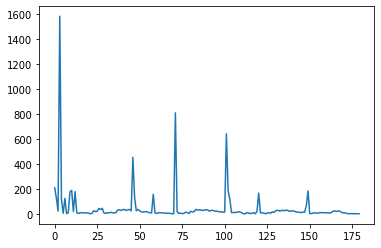

In [15]:
plt.plot(results_2d)
print("mean eror in 2d", np.mean(results_2d), "m")
print("median eror in 2d", np.median(results_2d), "m")
print("std in 2d", np.std(results_2d))

mean eror in 3d 76.6890025492015 m
median eror in 3d 85.49277172648219 m


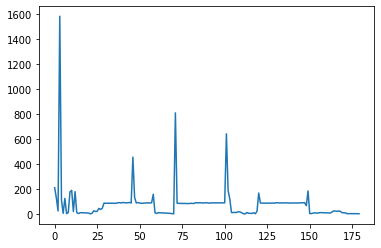

In [16]:
plt.plot(results_3d)
print("mean eror in 3d", np.mean(results_3d), "m")
print("median eror in 3d", np.median(results_3d), "m")

In [65]:

import folium
import time

# Plot the sources and the estimated location of the receiver on a 2D map

# Plot the sources
for i in range(len(estimated_locations)):
    m = folium.Map(location=[46.068725,11.227252 ], zoom_start=18, max_zoom=20)

    folium.Marker(location=estimated_locations[i][1][:2], icon=folium.Icon(color='purple')).add_to(m)
    folium.Marker(location=answer_locations[i][:2], icon=folium.Icon(color='green')).add_to(m)
    folium.Marker(location=[source_locations[0][0], source_locations[0][1]], icon=folium.Icon(color='red')).add_to(m)
    folium.Marker(location=[source_locations[1][0], source_locations[1][1]], icon=folium.Icon(color='red')).add_to(m)
    folium.Marker(location=[source_locations[2][0], source_locations[2][1]], icon=folium.Icon(color='red')).add_to(m)
    folium.Marker(location=[source_locations[3][0], source_locations[3][1]], icon=folium.Icon(color='red')).add_to(m)
    folium.Circle(location=[source_locations[0][0], source_locations[0][1]], radius=d_list[i][0], color='red', fill=False).add_to(m)
    folium.Circle(location=[source_locations[1][0], source_locations[1][1]], radius=d_list[i][1], color='red', fill=False).add_to(m)
    folium.Circle(location=[source_locations[2][0], source_locations[2][1]], radius=d_list[i][2], color='red', fill=False).add_to(m)
    folium.Circle(location=[source_locations[3][0], source_locations[3][1]], radius=d_list[i][3], color='red', fill=False).add_to(m)


    display(m, clear=True)
    time.sleep(0.5)

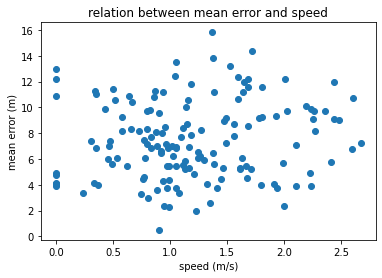

In [8]:
# evaluate speed and accuracy
speed_list = []
for i in range(len(answer_locations)):
    if i == 0:
        speed = np.linalg.norm(np.array(to_cartesian(*answer_locations[i]))-np.array(to_cartesian(*answer_locations[i+1]))) # m/s
    elif i == len(answer_locations)-1:
        speed = np.linalg.norm(np.array(to_cartesian(*answer_locations[i-1]))-np.array(to_cartesian(*answer_locations[i]))) # m/s
    else:
        speed = np.linalg.norm(np.array(to_cartesian(*answer_locations[i-1]))-np.array(to_cartesian(*answer_locations[i+1])))/2 # m/s
    speed_list.append(speed)
plt.figure(facecolor="white")
plt.scatter(speed_list,results_2d)
plt.xlabel('speed (m/s)')
plt.ylabel('mean error (m)')
plt.title('relation between mean error and speed')
plt.show()

In [ ]:
# weight late data